In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
# Changed from before due to new placement of Track, concat_tracks
from deepcell_tracking.utils import load_trks
from deepcell.data.tracking import Track, concat_tracks
##############
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.8.0


# Load dictionaries of usable (non-blank, non-border) images

In [2]:
import json
def load_img_dict(file):
    f = open(file)
    d = json.load(f)
    d = {int(k1): {int(k2): {int(k3): v for k3, v in d[k1][k2].items()} for k2, d[k1][k2] in d[k1].items()} for k1, d[k1] in d.items()}
    return d
def load_img_idx_dict(file):
    f = open(file)
    d = json.load(f)
    d = {int(k): v for k, v in d.items()}
    return d

In [3]:
# Of the form {batch: {cell: {frame: -1/idx, ...}, ...}, ...} where good_imgs[batch][cell][frame] = -1 if the image
# is blank/on the border and idx if it is usable, where idx is the position in the list of usable images
train_good_imgs = load_img_dict('/data/dataset_pruning/train_appearances_dict.json')
train_blank_imgs = load_img_dict('/data/dataset_pruning/train_blank_dict.json')
train_border_imgs = load_img_dict('/data/dataset_pruning/train_border_dict.json')
val_good_imgs = load_img_dict('/data/dataset_pruning/val_appearances_dict.json')
val_blank_imgs = load_img_dict('/data/dataset_pruning/val_blank_dict.json')
val_border_imgs = load_img_dict('/data/dataset_pruning/val_border_dict.json')

In [4]:
train_good_imgs[0]

{0: {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  11: 11,
  12: 12,
  13: 13,
  14: 14,
  15: 15,
  16: 16,
  17: 17,
  18: 18,
  19: 19,
  20: 20,
  21: 21,
  22: 22,
  23: 23,
  24: 24,
  25: 25,
  26: 26,
  27: 27,
  28: 28,
  29: 29,
  30: 30,
  31: 31,
  32: 32,
  33: 33,
  34: 34,
  35: 35,
  36: 36,
  37: 37,
  38: 38,
  39: 39,
  40: 40,
  41: 41,
  42: 42,
  43: 43,
  44: 44,
  45: 45,
  46: 46,
  47: 47,
  48: 48,
  49: 49,
  50: -1,
  51: -1,
  52: -1,
  53: -1,
  54: -1,
  55: -1,
  56: -1,
  57: -1,
  58: -1,
  59: -1,
  60: -1,
  61: -1,
  62: -1,
  63: -1,
  64: -1,
  65: -1,
  66: -1,
  67: -1,
  68: -1,
  69: -1,
  70: -1},
 1: {0: 50,
  1: 51,
  2: 52,
  3: 53,
  4: 54,
  5: 55,
  6: 56,
  7: 57,
  8: 58,
  9: 59,
  10: 60,
  11: 61,
  12: 62,
  13: 63,
  14: 64,
  15: 65,
  16: 66,
  17: 67,
  18: 68,
  19: 69,
  20: 70,
  21: 71,
  22: 72,
  23: 73,
  24: 74,
  25: 75,
  26: 76,
  27: 77,
  28: 78,
  29: 79,
  30: 80,
  3

In [74]:
def get_lst_idx_to_pos(good_imgs_dict):
    lst_idx_to_pos = {}
    for b in good_imgs_dict.keys():
        for c in good_imgs_dict[b].keys():
            for f in good_imgs_dict[b][c].keys():
                idx = good_imgs_dict[b][c][f]
                if idx != -1:
                    lst_idx_to_pos = (b, f, c)
    return lst_idx_to_pos

# Dictionary of frames to split (time until splitting) for each image, in the format of usable image dictionary
def get_life_cycle_dict(tracks):
    batches, frames, cells = tracks.centroids.shape[:3]
    
    life_cycle_dict = {}
    for batch in range(batches):
        life_cycle_dict[batch] = {}
        for cell in range(cells):
            life_cycle_dict[batch][cell] = {}
            for frame in range(frames):
                life_cycle_dict[batch][cell][frame] = -1
    
    for batch in range(batches):
        for cell in tracks.lineages[batch].keys():
            if len(tracks.lineages[batch][cell]['daughters']) != 0:
                cell_frames = tracks.lineages[batch][cell]['frames']
                last_frame = cell_frames[-1]
                for cell_frame in cell_frames:
                    life_cycle_dict[batch][cell - 1][cell_frame] = last_frame - cell_frame + 1
    
    return life_cycle_dict

# Should the cells in the dictionary be 0-indexed? What is the case in the good_imgs_dict?
# Yes. It is 0-indexed wrt the cells

In [39]:
type(train_tracks.lineages)

list

In [41]:
train_tracks.lineages[0].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [44]:
# Only cells are 1-indexed
train_tracks.lineages[0][1]['frames']

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49]

In [49]:
train_life_cycle_dict = get_life_cycle_dict(train_tracks)
val_life_cycle_dict = get_life_cycle_dict(val_tracks)

In [45]:
train_good_imgs[0].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [52]:
from skimage.exposure import rescale_intensity

def old_norm(X, size):
    X_norm = histogram_normalization(X, kernel_size=size)
    
    X_rescaled = np.zeros(X_norm.shape)
    for img_idx in range(X.shape[0]):
        x = X[img_idx]
        x = rescale_intensity(x, out_range=(0,1))
        X_rescaled[img_idx] = x
            
    return X_rescaled

In [56]:
# from skimage.exposure import rescale_intensity

# def norm(X, size):
#     X_norm = histogram_normalization(X, kernel_size=size)
    
#     X_rescaled = np.zeros(X_norm.shape)
#     for img_idx in range(X.shape[0]):
#         x = X[img_idx]
#         x = rescale_intensity(x, out_range=(0,1))
#         X_rescaled[img_idx] = x
            
#     return X_rescaled



# What is X? We can see in write_tracking_dataset_to_tfr, that we set app = norm(track.appearances, 64)

# What is app in Van Valen's code?
#     trk_data = load_trks(train_path) (what train_trks is for me)
#     I get 

# Shape of X 

def norm(X):
    X_rescaled = np.zeros(X.shape)

    for b in range(X.shape[0]):
        for f in range(X.shape[1]):
            for c in range(X.shape[2]):
                app = np.copy(X[b, f, c])
                idx = np.nonzero(app)
                if len(idx) > 0:
                    mean = np.mean(app[np.nonzero(app)])
                    std = np.std(app[np.nonzero(app)])

                    app[np.nonzero(app)] = (app[np.nonzero(app)] - mean) / std

                X_rescaled[b, f, c] = app

    return X_rescaled

In [53]:
val_tracks.appearances.shape

(27, 71, 277, 64, 64, 1)

In [74]:
app = val_tracks.appearances[0][0][0]
np.nonzero(app)
print(app[np.nonzero(app)])
mean = np.mean(app[np.nonzero(app)])
std = np.std(app[np.nonzero(app)])
print(mean, std)

[-0.93320346 -0.769327   -0.49970767 -0.04140493  0.3206768   0.6389078
  1.0618794   0.92431337  1.3710897   1.6732838   1.9098271   2.1664166
  2.5590684   2.3533459   2.1571453   2.1872144   2.0992622   1.995524
  1.716884    1.6138974   1.2638433   1.0568678   0.9766837   0.33220327
 -0.01334046 -0.37667507 -0.7259774  -0.8740676  -0.9973508  -0.89812285
 -0.5641056  -0.24737805  0.13725547  0.47227502  0.79626924  1.0776657
  1.4207036   1.5176764   1.9529262   2.0624278   2.335555    2.0441356
  2.065184    2.0052965   1.7449484   1.6910747   1.382115    1.2961676
  1.1257762   0.8115544   0.5654892   0.18511541 -0.25314128 -0.580393
 -0.8522675  -0.93595976 -1.0266681  -0.93621033 -0.7838604  -0.4573604
 -0.02862557  0.3976035   0.63690317  0.7920095   1.3352573   1.4585406
  1.6848103   1.7747669   1.9764802   1.6757896   1.5863341   1.585833
  1.3500413   1.3858737   1.135298    1.1064818   0.8381154   0.4211576
  0.15830381 -0.2243251  -0.45310062 -0.72196823 -0.8740676  -1.0

In [77]:
mean = np.mean(app)
std = np.std(app)
print(mean, std)

-1.8626451e-09 0.24951124


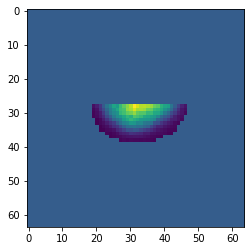

In [75]:
import matplotlib.pyplot as plt

# batch, frame, cell
x = np.array([val_tracks.appearances[0][0][0]])
fig, ax = plt.subplots()
ax.imshow(x[0])

In [30]:
old_norm_app.shape

(27, 71, 277, 64, 64, 1)

In [5]:
# train_trks = load_trks(os.path.join('/data/tracking-nuclear', 'train.trks'))
val_trks = load_trks(os.path.join('/data/tracking-nuclear', 'val.trks'))

In [32]:
X = val_trks['X'].astype('float32')

In [33]:
type(X)

numpy.ndarray

In [6]:
with tf.device('/cpu:0'):
    val_tracks = Track(tracked_data=val_trks,
                   appearance_dim=64,
                   distance_threshold=64,
                   crop_mode='fixed')

    print('Done creating Track objects.')

#     write_tracking_dataset_to_tfr(val_tracks, filename='val_big', good_imgs=val_good_imgs)

2022-11-26 00:16:09.741656: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 00:16:11.197598: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:06:00.0, compute capability: 6.1
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [03:26<00:00,  7.63s/it]


Done creating Track objects.


In [12]:
type(val_tracks.appearances)

numpy.ndarray

In [17]:
len(val_tracks.appearances)

27

In [18]:
len(val_tracks.appearances[0])

71

In [19]:
len(val_tracks.appearances[0][0])

277

In [20]:
len(val_tracks.appearances[0][0][0])

64

In [21]:
len(val_tracks.appearances[0][0][0][0])

64

In [22]:
with tf.device('/cpu:0'):
    val_tracks_small = Track(tracked_data=val_trks,
                   appearance_dim=32,
                   distance_threshold=64,
                   crop_mode='resize')

    print('Done creating Track objects.')

#     write_tracking_dataset_to_tfr(val_tracks, filename='val_big', good_imgs=val_good_imgs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [02:48<00:00,  6.25s/it]


Done creating Track objects.


In [28]:
app_type = val_tracks.appearances.dtype
old_norm_app = old_norm(val_tracks.appearances, 64).astype(app_type)

In [29]:
type(old_norm_app)

numpy.ndarray

In [68]:
val_tracks.appearances.shape

(27, 71, 277, 64, 64, 1)

[1.3255142]
[0.]


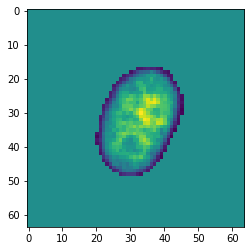

In [50]:
import matplotlib.pyplot as plt

# batch, frame, cell
x = np.array([val_tracks.appearances[26][2][16]])
fig, ax = plt.subplots()
ax.imshow(x[0])
print(x[0, 30, 35])
print(x[0, 0, 60])

[0.58282375]
[0.44303143]


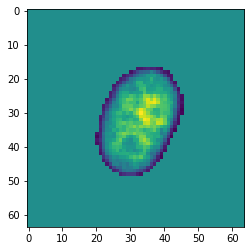

In [51]:
x = np.array([old_norm_app[26][2][16]])
fig, ax = plt.subplots()
ax.imshow(x[0])
print(x[0, 30, 35])
print(x[0, 0, 60])

In [65]:
app_type = val_tracks.appearances.dtype
norm_app = norm(val_tracks.appearances).astype(app_type)

3


In [66]:
norm_app.shape

(27, 71, 277, 64, 64, 1)

[1.3255143]
[0.]


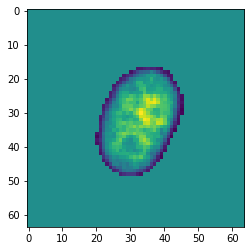

In [67]:
x = np.array([norm_app[26][2][16]])
fig, ax = plt.subplots()
ax.imshow(x[0])
print(x[0, 30, 35])
print(x[0, 0, 60])

In [ ]:
import matplotlib.pyplot as plt

x = np.array([val_tracks.appearances[26][2][16]])
fig, ax = plt.subplots()
ax.imshow(x[0])

In [7]:
with tf.device('/cpu:0'):
    train_tracks = Track(tracked_data=train_trks,
                   appearance_dim=64,
                   distance_threshold=64,
                   crop_mode='fixed')

    print('Done with creating Track objects.')

    write_tracking_dataset_to_tfr(train_tracks, filename='train_big', good_imgs=train_good_imgs)

 33%|██████████████▏                            | 30/91 [05:43<13:02, 12.83s/it]/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████████████| 91/91 [13:49<00:

Done with creating Track objects.
